## 提高神经网络性能  
通过将特征标准化，并应用各种优化算法来提高神经网络的性能。


In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    #创建一个新的目标特征，即median_house_value_is_high
    #通过median_house_value是否大于265000来判断
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2636.0,538.5,1429.1,500.4,3.9,2.0
std,2.1,2.0,12.6,2174.2,421.3,1166.8,384.5,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1465.0,298.0,792.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2125.0,433.0,1167.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3136.0,645.2,1718.0,602.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.4,2662.2,541.6,1430.7,503.2,3.9,2.0
std,2.1,2.0,12.6,2193.8,421.9,1101.2,384.7,1.9,1.1
min,32.6,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.7,18.0,1450.0,294.0,783.0,278.0,2.6,1.5
50%,34.3,-118.5,28.0,2145.0,435.0,1168.0,409.0,3.5,2.0
75%,37.7,-118.0,37.0,3192.0,658.0,1733.2,612.0,4.8,2.3
max,42.0,-114.6,52.0,30405.0,4798.0,12873.0,4490.0,15.0,29.4


Training targets summary:


,median_house_value
count,12000.0
mean,207.7
std,115.9
min,15.0
25%,120.6
50%,180.2
75%,265.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.3
std,116.3
min,15.0
25%,116.8
50%,180.5
75%,264.8
max,500.0


### 训练神经网络

In [4]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_features)
               for my_features in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """构建输入函数
    """
    
    # Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [19]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear regressor object.
   #使用丢弃正则化
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer
    )
  
  # Create input functions
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
    # Train the model, starting from the prior state.
        dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
        )
    # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 179.49
  period 01 : 172.93
  period 02 : 161.38
  period 03 : 151.69
  period 04 : 141.03
  period 05 : 127.49
  period 06 : 114.02
  period 07 : 106.89
  period 08 : 103.06
  period 09 : 102.58
Model training finished.
Final RMSE (on training data):   102.58
Final RMSE (on validation data): 103.27


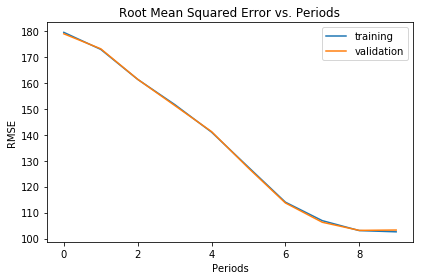

In [8]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### 线性缩放  
将输入标准化以使其位于（-1,1）范围内可能是一种良好的标准做法。  
这样会使得SGD在一个维度中采取很大步长（或在另一位中采用很小步长）时不会受阻。这种做法和使用预调节器（Preconditioner）的想法是有联系的。

In [20]:
def linear_scale(series):
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x: ((x - min_val) / scale) - 1.0)

### 使用线性缩放将特征标准化  
将输入标准化到（-1,1）这一范围内。

In [21]:
def normalize_linear_scale(examples_dataframe):
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
    processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
    processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
    processed_features["population"] = linear_scale(examples_dataframe["population"])
    processed_features["households"] = linear_scale(examples_dataframe["households"])
    processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
    processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
    return processed_features
normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

Training model...
RMSE (on training data):
  period 00 : 164.94
  period 01 : 115.23
  period 02 : 104.06
  period 03 : 88.27
  period 04 : 77.68
  period 05 : 75.06
  period 06 : 73.46
  period 07 : 72.66
  period 08 : 71.85
  period 09 : 71.45
Model training finished.
Final RMSE (on training data):   71.45
Final RMSE (on validation data): 71.15


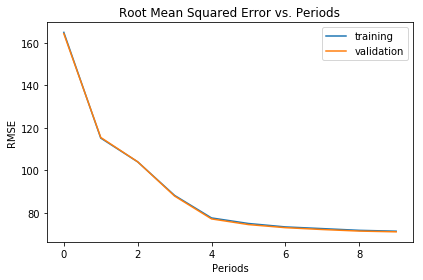

In [13]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 尝试使用其他优化器  
使用AdaGrad和Adam优化器。  
AdaGrad优化器的核心是灵活地修改模型中每个系数的学习率，从而单调降低有效的学习率。该优化器对凸优化问题非常有效，但不一定适用于非凸优化问题的神经网络训练。通过指定 AdagradOptimizer（而不是 GradientDescentOptimizer）来使用 AdaGrad。请注意，对于 AdaGrad，您可能需要使用较大的学习率。

Training model...
RMSE (on training data):
  period 00 : 71.20
  period 01 : 75.73
  period 02 : 71.10
  period 03 : 67.85
  period 04 : 69.76
  period 05 : 67.88
  period 06 : 67.04
  period 07 : 66.37
  period 08 : 66.01
  period 09 : 66.63
Model training finished.
Final RMSE (on training data):   66.63
Final RMSE (on validation data): 66.24


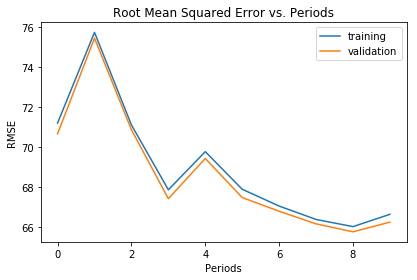

In [22]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

使用Adam优化器，对于非凸优化问题，他有时比Adagrad更有效。要使用 Adam，请调用 tf.train.AdamOptimizer 方法。此方法将几个可选超参数作为参数

Training model...
RMSE (on training data):
  period 00 : 206.72
  period 01 : 122.60
  period 02 : 112.66
  period 03 : 104.28
  period 04 : 89.84
  period 05 : 75.86
  period 06 : 72.34
  period 07 : 71.29
  period 08 : 71.12
  period 09 : 70.40
Model training finished.
Final RMSE (on training data):   70.40
Final RMSE (on validation data): 70.06


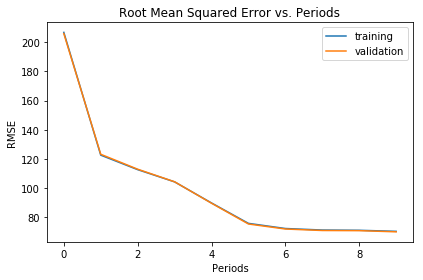

In [23]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

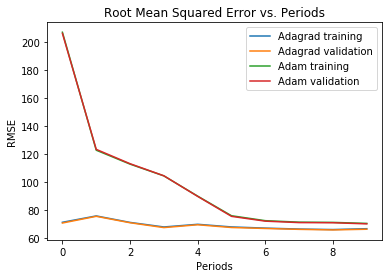

In [24]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

### 尝试其他标准化方法  


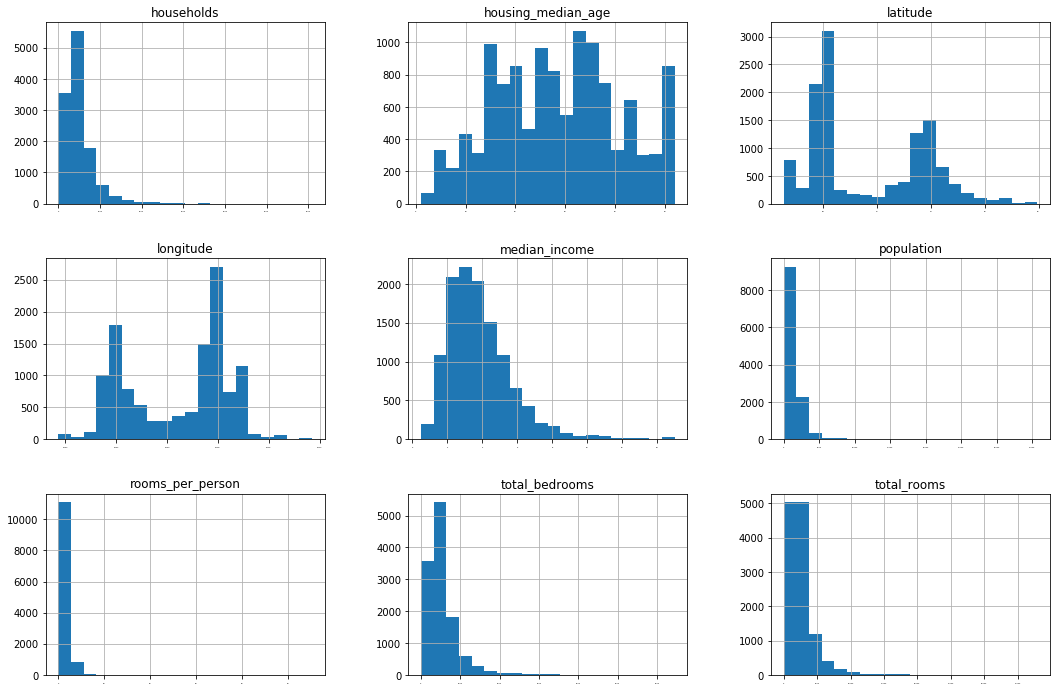

In [25]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=2)

通过选择其他方式来转换这些特征，可能会得到更好的效果。  
例如，对数缩放可能对某些特征有帮助。或者，截取极端值可能会使剩余部分的信息更加丰富。

In [26]:
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(
        min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

households、median_income 和 total_bedrooms 在对数空间内均呈现为正态分布。

如果 latitude、longitude 和 housing_median_age 像之前一样进行线性缩放，效果可能会更好。

population、totalRooms 和 rooms_per_person 具有几个极端离群值。这些值似乎过于极端，以至于我们无法利用对数标准化处理这些离群值。因此，我们直接截取掉这些值

Training model...
RMSE (on training data):
  period 00 : 211.72
  period 01 : 132.22
  period 02 : 114.76
  period 03 : 113.35
  period 04 : 111.64
  period 05 : 109.75
  period 06 : 107.29
  period 07 : 104.02
  period 08 : 100.07
  period 09 : 95.52
Model training finished.
Final RMSE (on training data):   95.52
Final RMSE (on validation data): 95.65


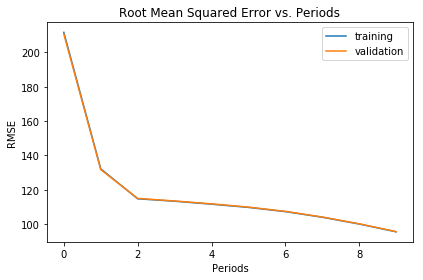

In [27]:
def normalize(examples_dataframe):

    processed_features = pd.DataFrame()

    processed_features["households"] = log_normalize(examples_dataframe["households"])
    processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
    processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

    processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
    processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

    return processed_features
normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### 挑战  
仅使用经纬度

Training model...
RMSE (on training data):
  period 00 : 80.87
  period 01 : 71.29
  period 02 : 69.99
  period 03 : 68.88
  period 04 : 68.18
  period 05 : 67.02
  period 06 : 66.57
  period 07 : 66.23
  period 08 : 66.13
  period 09 : 65.71
Model training finished.
Final RMSE (on training data):   65.71
Final RMSE (on validation data): 65.66


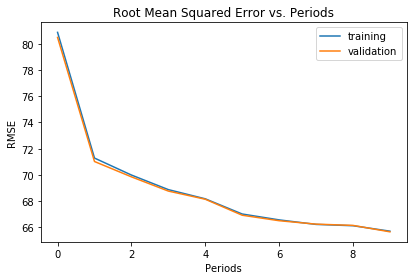

In [33]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#
def normalize(examples_dataframe):

    processed_features = pd.DataFrame()

    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])

    return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10, 10, 10, 5,],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

In [ ]:
def location_location_location(examples_dataframe):
 
    processed_features = pd.DataFrame()
    processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
    processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
    return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)